# Final Project: Small Files and Map Reduce

**Background:** MapReduce model was initially designed to process large amounts of data, where data usually persisted in large files. Initially MapReduce and HDFS were collocated. Data persisted in HDFS where each file is chunked into blocks, usually of 64MB size. Data partitioner of MapReduce framework will partition input dataset and decide on number of the map tasks to be launched across MapReduce cluster. When MapReduce job read a data from HDFS, then usually a single map task assigned to process a single HDFS block. In case data persisted in object storage, then MapReduce frameworks use “virtual” chunks and assign each map to read a particular byte range from the data. As example, when virtual block size is 64MB and data object is 80MB, then the first map will read 0-64MB offset from the file, while second map task will read the remaining offset, which is 64MB-80MB chunk. When the file size is below the chunk size, a single map will process entire file as is.

**Problem statement:** While the approach above is very efficient when the input files are sufficiently large, it has a major drawback when the input files are small, less below the chunk size. Both HDFS and MapReduce execution framework will suffer from different issues affecting their performance and effectiveness. There are various research papers on the topic of running MapReduce on small files. As example, the bibliography section contains two papers describing some of the issues in HDFS and in MapReduce. Both papers try to come with a solution to resolve small files issues in MapReduce.

**Project definition:** In this project students will explore challenges of executing MapReduce over small files persisted in the object storage. Students will define the problem and come with prototype solution.

**Project scope:** Project will be submitted as a pdf paper accompanied with a prototype code. 

### High Level Scope

Our project will compare executing MapReduce over small files (smaller than 64MB) and large files (larger then 64MB) using Lithops. It should be noted that 64MB was chosen because that is the default block size in HDFS.

We will:

* Run through the Lithops and AWS Cloud Storage (S3) setup
* Create small and large files, then upload to S3 bucket
* Execute MapReduce on both sets of small vs large files
* Compare time for both sets
* Propose a solution to handle the small files problem
* Implement such a solution

### Lithops Setup

In [1]:
%%capture
#!pip install lithops
!pip install boto3
!pip install git+https://github.com/lithops-cloud/lithops.git

In [2]:
config = {
    'lithops': {'backend': 'aws_lambda', 
                'storage': 'aws_s3',
                'log_level': 'INFO'},
    'aws':  {'access_key_id': 'x',
             'secret_access_key': 'x',
             'account_id': '170091767549'},
    'aws_s3': {'storage_bucket': 'bigdata-final-proj-gal-aggie',
               'region_name': 'us-east-2'},
    'aws_lambda': {'execution_role': 'arn:aws:iam::170091767549:role/bigdata-final-project-gal-aggie-role',
                'region_name': 'us-east-2'}
}       
# Using https://lithops-cloud.github.io/docs/source/storage_config/aws_s3.html        
# https://lithops-cloud.github.io/docs/source/configuration.html

### AWS Cloud Storage Setup

In [3]:
import lithops
import pandas as pd
import boto3
import os, sys
import sqlite3
from datetime import datetime
from io import StringIO

In [4]:
s3_client = boto3.client(
    's3',
    aws_access_key_id='x',
    aws_secret_access_key='x'
)

s3_resource = boto3.resource(
    's3',
    aws_access_key_id='x',
    aws_secret_access_key='x'
  ) 

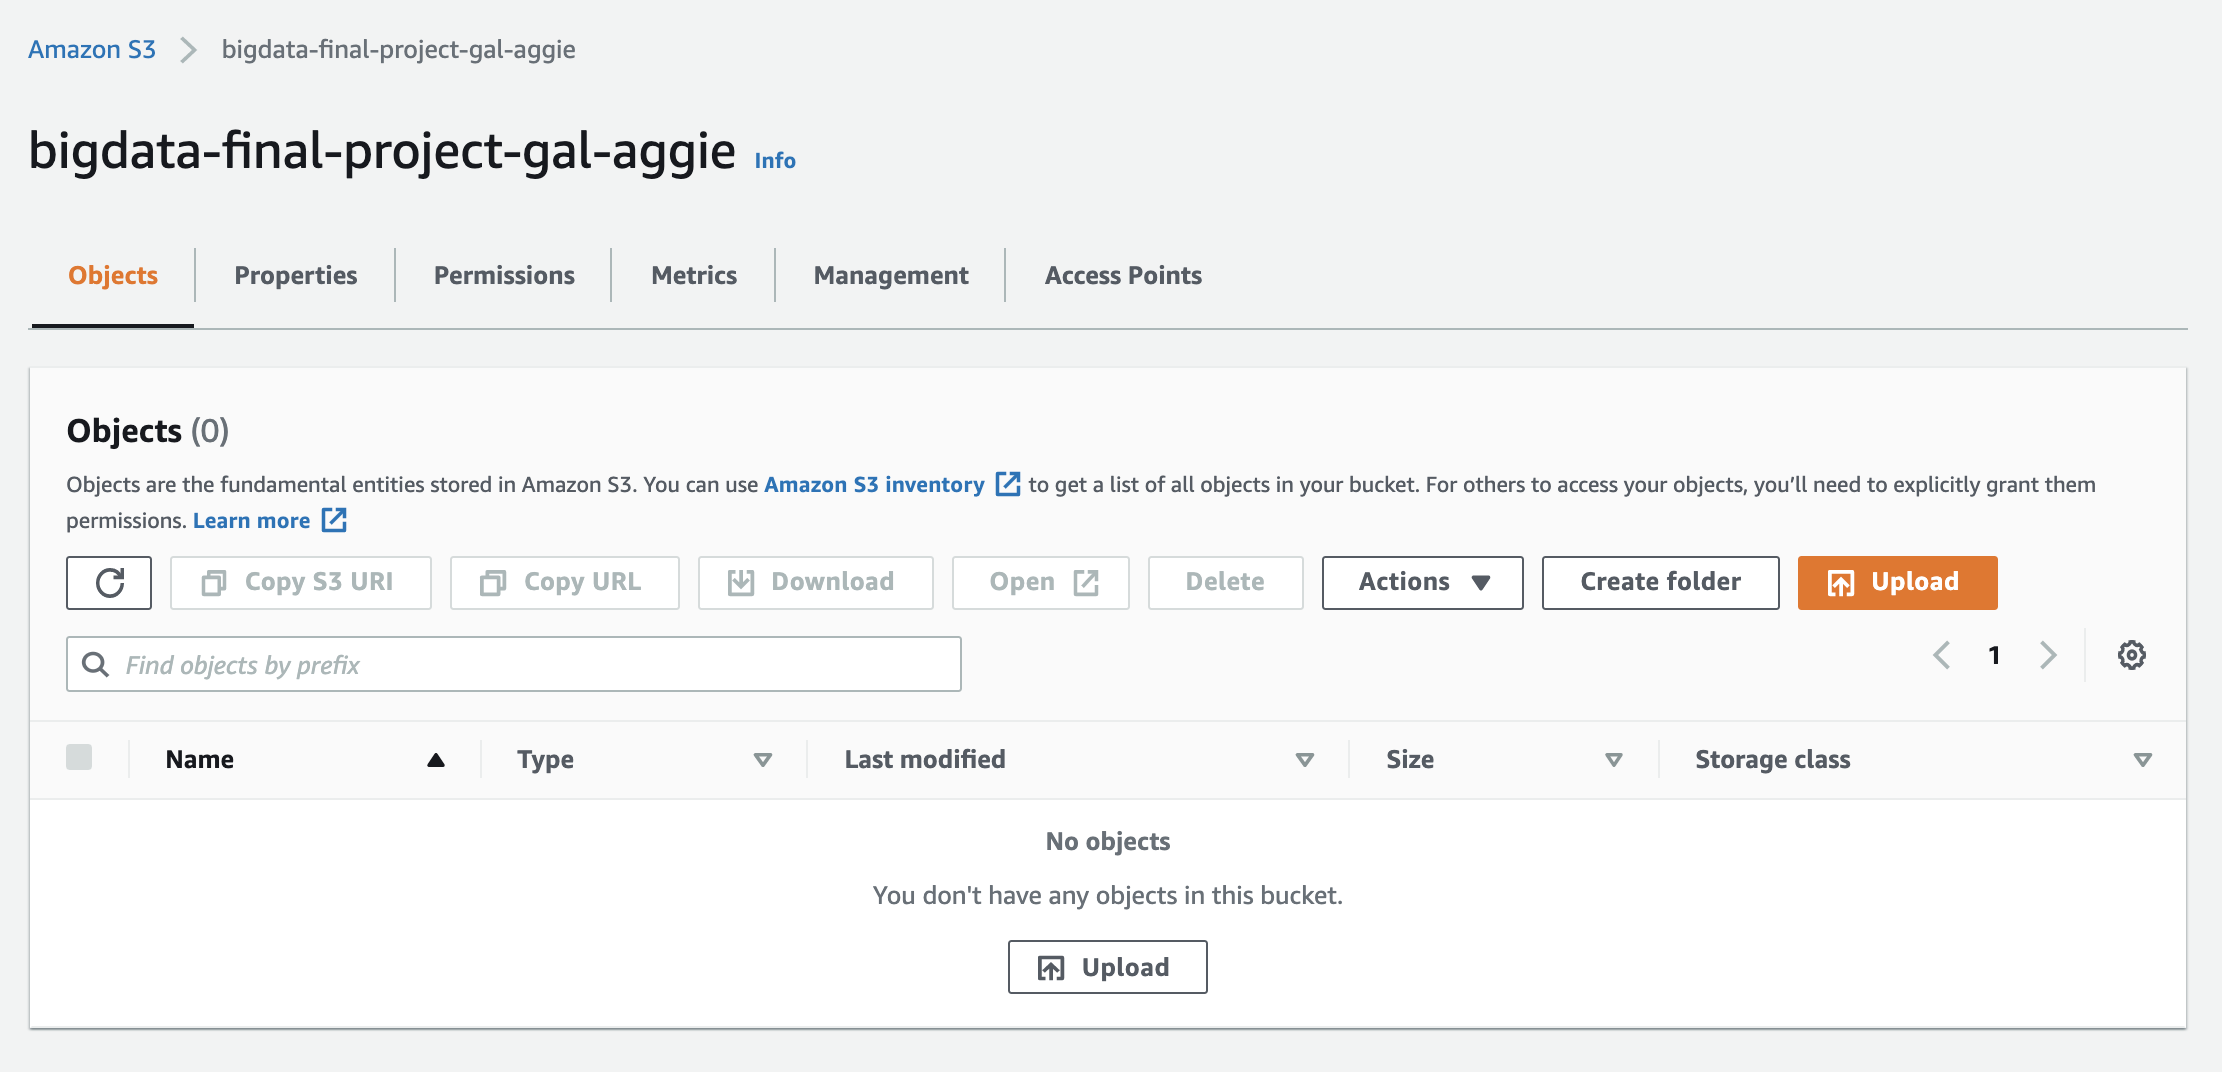

An empty S3 bucket has been created

### Create small and large files, then upload them to the cloud

This process was outsourced to a local Python script, rather than on Jupyter notebook. The script will create 1000 small files, where each file is of size 100KB and create 1 large file, which is of size 100MB. Once those files are created locally, they are uploaded to separate folders within the S3 bucket. The result of running the script will be all the small files uploaded to the 'smallFiles/' folder in the S3 bucket and all the large files uploaded to the 'largeFiles/' folder in the S3 bucket.

We decided to split it up like this so that both directories add up to 100MB of data in two different ways. The smallFiles/ folder makes up 100MB using 1000 small files of 1KB each, while the largeFiles/ folder makes up 100MB using 1 large file of 100MB. 

The script is called file_generation_upload.py and has been included in the project submission.

In our experiment, we can measure how long it takes to execute MapReduce on the same amount of data but that is split differently. 

In [5]:
def get_bucket_description(directory_name):
    
  response = s3_client.list_objects_v2(Bucket='bigdata-final-proj-gal-aggie', Prefix=directory_name, StartAfter=directory_name)
  number_of_files = len(response['Contents'])
  file_size_kb = int(response['Contents'][0]['Size'] / 1000)
  file_size_mb = int(response['Contents'][0]['Size'] / 1000000)

  my_bucket = s3_resource.Bucket('bigdata-final-proj-gal-aggie')
  total_size = 0
  for obj in my_bucket.objects.filter(Prefix=directory_name):
      total_size = total_size + obj.size
  total_size = int(total_size / 1000000)

  if directory_name == 'smallFiles/':
    print(f'The {directory_name} directory ({total_size+1}MB in size) contains {number_of_files} files, where each file is about {file_size_kb} KB.\n')
  else:
    print(f'The {directory_name} directory ({total_size}MB in size) contains {number_of_files} file, where each file is about {file_size_mb} MB.\n')

get_bucket_description('smallFiles/')
get_bucket_description('largeFiles/')

The smallFiles/ directory (100MB in size) contains 1000 files, where each file is about 100 KB.

The largeFiles/ directory (100MB in size) contains 1 file, where each file is about 100 MB.



Using the get_bucket_description() method, we can prove that indeed the smallFiles/ folder has 1000 small files (defined as being smaller than 64MB) and the largeFiles/ folder has 1 large file (defined as being larger than 64MB).

### Execute MapReduce on both sets of small vs large files

The following code has been taken from Assignment 3, but modified so that it uses a single map_reduce() function (rather than two map functions).

In [6]:
class MapReduceServerlessEngine():

  '''
  input_data: name of a folder in S3 [‘s3://bucket-name/folderName/’]
  map_function: a pointer to the function that returns a list where each entry of the form (key,value)
  reduce_function: a pointer to the function that returns a list where each entry of the form (key,value)
  params: parameters to the map_function of the form params={key:value} (which column to choose to map)
  '''
  @staticmethod
  def execute(input_data, map_function, reduce_function, params):

    global column_index
    column_index = params['column']

    print('STARTING MAPREDUCE...')

    # Deploy all map tasks as a serverless actions by using Lithops against AWS Lambda
    with lithops.ServerlessExecutor(config=config, log_level='INFO') as serverless_exec:
      
      # Run map
      serverless_exec.map_reduce(map_function, input_data, reduce_function)

      # Collect results 
      map_reduce_results = serverless_exec.get_result()

In [7]:
# Read cloud object, return a list that contains entries: (key_value, document_name) for the specific column index provided
# https://lithops-cloud.github.io/docs/source/data_processing.html
def inverted_map(obj):

  bucket_name = obj.bucket
  key = obj.key
  data = obj.data_stream.read()

  # list that contains entries of the form (key_value, document_name)
  results = []

  # for every line in the file
  for line in data.splitlines():

    # split from decoding
    for word in line.decode('utf-8').split():

      row_values = word.split(',')  # split by ,

      # extract the column to map
      map_value = row_values[column_index-1] #-1 because index starts at 0

      # create a tuple and append to results
      entry = (map_value, key)
      results.append(entry)

  # [('John', '/bucket-name/myCSV[1].csv'), ('Albert', '/name/myCSV[1].csv'), ...]
  return results[1:]

# results is a list of lists per given file (might have duplicates)
# Return a new list without duplicates
def inverted_reduce(results):

  reduce_results = {}

  # [[file1], [file2]]
  for index in results:
    for res in index: #[file1]

      #('John', '/bucket-name/myCSV[1].csv')
      value = res[0] 
      location = res[1]

      # build a dictionary
      if value in reduce_results:
        reduce_results[value].append(location)
      else:
        reduce_results[value] = []
        reduce_results[value].append(location)

  # consolidate dictionary
  for key in reduce_results:
    reduce_results[key] = list(set(reduce_results[key]))

  return reduce_results


In [8]:
input_data = ['bigdata-final-proj-gal-aggie/smallFiles/']

mapreduce = MapReduceServerlessEngine()

# params= column:1 for first_name, column:2 for second_name, column:3 for city
start_time = datetime.now()
mapreduce.execute(input_data, inverted_map, inverted_reduce, params={'column':1})
end_time = datetime.now()
total_time_small = end_time - start_time

2022-02-15 18:19:23,225 [INFO] lithops.config -- Lithops v2.5.9.dev0
2022-02-15 18:19:23,238 [INFO] lithops.storage.backends.aws_s3.aws_s3 -- S3 client created - Region: us-east-2


STARTING MAPREDUCE...


2022-02-15 18:19:23,301 [INFO] lithops.serverless.backends.aws_lambda.aws_lambda -- AWS Lambda client created - Region: us-east-2
2022-02-15 18:19:23,303 [INFO] lithops.invokers -- ExecutorID 7a18bd-0 | JobID M000 - Selected Runtime: python37 - 256MB
2022-02-15 18:19:24,521 [INFO] lithops.invokers -- ExecutorID 7a18bd-0 | JobID M000 - Starting function invocation: inverted_map() - Total: 1001 activations
2022-02-15 18:19:25,182 [INFO] lithops.invokers -- ExecutorID 7a18bd-0 | JobID M000 - View execution logs at /tmp/lithops/logs/7a18bd-0-M000.log
2022-02-15 18:19:25,478 [INFO] lithops.wait -- ExecutorID 7a18bd-0 - Waiting for 20% of 1001 function activations to complete


    0%|          | 0/201  

2022-02-15 18:19:31,233 [INFO] lithops.invokers -- ExecutorID 7a18bd-0 | JobID R000 - Selected Runtime: python37 - 256MB


2022-02-15 18:19:32,527 [INFO] lithops.invokers -- ExecutorID 7a18bd-0 | JobID R000 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-02-15 18:19:32,538 [INFO] lithops.invokers -- ExecutorID 7a18bd-0 | JobID R000 - View execution logs at /tmp/lithops/logs/7a18bd-0-R000.log
2022-02-15 18:19:32,568 [INFO] lithops.wait -- ExecutorID 7a18bd-0 - Getting results from 1002 function activations


    0%|          | 0/1002  

2022-02-15 18:19:46,470 [INFO] lithops.executors -- ExecutorID 7a18bd-0 - Cleaning temporary data


In [9]:
input_data = ['bigdata-final-proj-gal-aggie/largeFiles/']

# params= column:1 for first_name, column:2 for second_name, column:3 for city
start_time = datetime.now()
mapreduce.execute(input_data, inverted_map, inverted_reduce, params={'column':1})
end_time = datetime.now()
total_time_large = end_time - start_time

2022-02-15 18:19:46,538 [INFO] lithops.config -- Lithops v2.5.9.dev0
2022-02-15 18:19:46,559 [INFO] lithops.storage.backends.aws_s3.aws_s3 -- S3 client created - Region: us-east-2
2022-02-15 18:19:46,650 [INFO] lithops.serverless.backends.aws_lambda.aws_lambda -- AWS Lambda client created - Region: us-east-2
2022-02-15 18:19:46,658 [INFO] lithops.invokers -- ExecutorID 7a18bd-1 | JobID M000 - Selected Runtime: python37 - 256MB


STARTING MAPREDUCE...


2022-02-15 18:19:47,082 [INFO] lithops.invokers -- ExecutorID 7a18bd-1 | JobID M000 - Starting function invocation: inverted_map() - Total: 1 activations
2022-02-15 18:19:47,090 [INFO] lithops.invokers -- ExecutorID 7a18bd-1 | JobID M000 - View execution logs at /tmp/lithops/logs/7a18bd-1-M000.log
2022-02-15 18:19:47,095 [INFO] lithops.wait -- ExecutorID 7a18bd-1 - Waiting for 20% of 1 function activations to complete


    0%|          | 0/1  

2022-02-15 18:20:02,183 [INFO] lithops.invokers -- ExecutorID 7a18bd-1 | JobID R000 - Selected Runtime: python37 - 256MB


2022-02-15 18:20:02,422 [INFO] lithops.invokers -- ExecutorID 7a18bd-1 | JobID R000 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-02-15 18:20:02,429 [INFO] lithops.invokers -- ExecutorID 7a18bd-1 | JobID R000 - View execution logs at /tmp/lithops/logs/7a18bd-1-R000.log
2022-02-15 18:20:02,431 [INFO] lithops.wait -- ExecutorID 7a18bd-1 - Getting results from 2 function activations


    0%|          | 0/2  

2022-02-15 18:20:08,546 [INFO] lithops.executors -- ExecutorID 7a18bd-1 - Cleaning temporary data


### Compare time and memory for both sets


In this experiment, we measured the processing performance for a large number of small files compared with just only one large file, with the total
data size being the same.

In [10]:
print(f'As observed from the experment.....')
print(f'The total time for executing map_reduce() on 1000 small files is : {total_time_small.total_seconds()} seconds')
print(f'The total time for executing map_reduce() on 1 large file is : {total_time_large.total_seconds()} seconds\n')

difference = total_time_small - total_time_large
print(f'The map_reduce() execution for 1 large file is {difference.total_seconds()} seconds faster than for 1000 small files of the same size\n')

print(f'Now imagine what that time difference would look like on a large, production level scale....')

As observed from the experment.....
The total time for executing map_reduce() on 1000 small files is : 23.279512 seconds
The total time for executing map_reduce() on 1 large file is : 22.040406 seconds

The map_reduce() execution for 1 large file is 1.239106 seconds faster than for 1000 small files of the same size

Now imagine what that time difference would look like on a large, production level scale....


### Propose a solution to handle the small files problem


In order to fix the small files problem in MapReduce through cloud storage, we propose iterating through each small files and concatenating the data within into one large file, uploading that combined large file to the cloud and then executing that one large file in map_reduce.

### Implement the solution

In [11]:
# create the foundation for a large DF
total_data = pd.DataFrame(columns=['firstname', 'secondname', 'city'])

# get the name of all the files in the smallFiles/ directory
response = s3_client.list_objects_v2(Bucket='bigdata-final-proj-gal-aggie', Prefix='smallFiles/', StartAfter='smallFiles/')

# for every small file, extract the DF and append it to a list
small_df_list = []
for obj in response["Contents"]:
  key = obj['Key']
  s3_obj = s3_client.get_object(Bucket='bigdata-final-proj-gal-aggie', Key=key)
  df_obj = pd.read_csv(s3_obj['Body'], on_bad_lines='skip')
  small_df_list.append(df_obj)

# concatenate the small DFs of every small file into one
total_data = pd.concat(small_df_list)

# store that combined dataframe into combinedSmallFiles/ folder
csv_buffer = StringIO()
total_data.to_csv(csv_buffer)
s3_resource.Object('bigdata-final-proj-gal-aggie', 'combinedSmallFiles/combined.csv').put(Body=csv_buffer.getvalue())

{'ETag': '"730661888f0dd92d65709ecd2bcc7744"',
 'ResponseMetadata': {'HTTPHeaders': {'content-length': '0',
   'date': 'Tue, 15 Feb 2022 18:21:43 GMT',
   'etag': '"730661888f0dd92d65709ecd2bcc7744"',
   'server': 'AmazonS3',
   'x-amz-id-2': 'tYl25k1U/a/ry7rwkaTsN7/Mx2b1jY85PStrl6uWbr6v1FbUHKVapXLfF5MRGLJaddLaC+1Ccas=',
   'x-amz-request-id': 'D9JRKPDEGN4W84PN'},
  'HTTPStatusCode': 200,
  'HostId': 'tYl25k1U/a/ry7rwkaTsN7/Mx2b1jY85PStrl6uWbr6v1FbUHKVapXLfF5MRGLJaddLaC+1Ccas=',
  'RequestId': 'D9JRKPDEGN4W84PN',
  'RetryAttempts': 0}}

In [12]:
# display details for that folder
get_bucket_description('combinedSmallFiles/')

The combinedSmallFiles/ directory (116MB in size) contains 1 file, where each file is about 116 MB.



Now, execute map_reduce() on the combined file..

In [13]:
input_data = ['bigdata-final-proj-gal-aggie/combinedSmallFiles/']

start_time = datetime.now()
mapreduce.execute(input_data, inverted_map, inverted_reduce, params={'column':1})
end_time = datetime.now()
total_time_combined = end_time - start_time

2022-02-15 18:21:44,692 [INFO] lithops.config -- Lithops v2.5.9.dev0
2022-02-15 18:21:44,700 [INFO] lithops.storage.backends.aws_s3.aws_s3 -- S3 client created - Region: us-east-2
2022-02-15 18:21:44,752 [INFO] lithops.serverless.backends.aws_lambda.aws_lambda -- AWS Lambda client created - Region: us-east-2
2022-02-15 18:21:44,754 [INFO] lithops.invokers -- ExecutorID 7a18bd-2 | JobID M000 - Selected Runtime: python37 - 256MB


STARTING MAPREDUCE...


2022-02-15 18:21:45,129 [INFO] lithops.invokers -- ExecutorID 7a18bd-2 | JobID M000 - Starting function invocation: inverted_map() - Total: 1 activations
2022-02-15 18:21:45,138 [INFO] lithops.invokers -- ExecutorID 7a18bd-2 | JobID M000 - View execution logs at /tmp/lithops/logs/7a18bd-2-M000.log
2022-02-15 18:21:45,142 [INFO] lithops.wait -- ExecutorID 7a18bd-2 - Waiting for 20% of 1 function activations to complete


    0%|          | 0/1  

2022-02-15 18:22:00,214 [INFO] lithops.invokers -- ExecutorID 7a18bd-2 | JobID R000 - Selected Runtime: python37 - 256MB
2022-02-15 18:22:00,313 [INFO] lithops.invokers -- ExecutorID 7a18bd-2 | JobID R000 - Starting function invocation: inverted_reduce() - Total: 1 activations
2022-02-15 18:22:00,318 [INFO] lithops.invokers -- ExecutorID 7a18bd-2 | JobID R000 - View execution logs at /tmp/lithops/logs/7a18bd-2-R000.log
2022-02-15 18:22:00,321 [INFO] lithops.wait -- ExecutorID 7a18bd-2 - Getting results from 2 function activations


    0%|          | 0/2  

2022-02-15 18:22:06,630 [INFO] lithops.executors -- ExecutorID 7a18bd-2 - Cleaning temporary data


In [14]:
print(f'As observed from the experment.....')
print(f'The total time for executing map_reduce() on the combined file is : {total_time_combined.total_seconds()} seconds\n')

diff = total_time_small - total_time_combined
print(f'The execution for the combined files is: {diff.total_seconds()} seconds faster than for the 1000 small files of the same size')
print(f'The total time for executing map_reduce() on 1 large file is : {total_time_large.total_seconds()} seconds\n')

As observed from the experment.....
The total time for executing map_reduce() on the combined file is : 21.980728 seconds

The execution for the combined files is: 1.298784 seconds faster than for the 1000 small files of the same size
The total time for executing map_reduce() on 1 large file is : 22.040406 seconds

